# Streaming Output

In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools=tools)

def model(state:AgentState):
    return{
        "messages":[llm_with_tools.invoke(state["messages"])],
    }

def tools_router(state: AgentState):
    last_message = state["messages"][-1]

    if(hasattr(last_message,"tool_calls") and len(last_message.tool_calls) > 0):
        return "tools"
    else:
        return "stops"


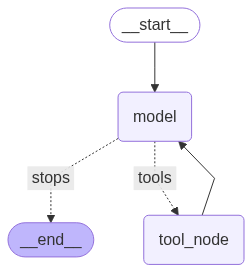

In [2]:
tool_node = ToolNode(tools=tools)
graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges("model", tools_router, {"tools":"tool_node","stops":END})
graph.add_edge("tool_node","model")

app = graph.compile()
app


In [3]:
input = {
    "messages":["What's the current weather in Lagos"]
}

events = app.stream(input=input, stream_mode="values")

for event in events:
    print(event)

{'messages': [HumanMessage(content="What's the current weather in Lagos", additional_kwargs={}, response_metadata={}, id='9bb5e231-f83e-4fe2-ae09-a9a7aebeb528')]}
{'messages': [HumanMessage(content="What's the current weather in Lagos", additional_kwargs={}, response_metadata={}, id='9bb5e231-f83e-4fe2-ae09-a9a7aebeb528'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YyKieFyAFZPtZHn4AmA1teIb', 'function': {'arguments': '{"query":"current weather in Lagos"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 85, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bth6BSyFF9uLSyXJyHM0Iqjxm34IB', 'service_tier':

In [4]:
input = {
    "messages":["What's the current weather in Lagos"]
}

events = app.stream(input=input, stream_mode="updates")

for event in events:
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vawVLm4NMpNdXHkGCxmF1p1D', 'function': {'arguments': '{"query":"current weather in Lagos"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 85, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-Bth6SYV5GBijogcclbNSHq9hQlIyD', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c52dd552-cde6-4bfc-9f36-1cc051f6de96-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Lagos'}, 'id': 'call_vawVLm4NMpNdXHkGCxmF1p1D', 'type': 'tool_call'}], usage_metadata={'input_tokens

## use async Event .astream method

In [5]:
input = {
    "messages":["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events:
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '7cbcc44c-2e00-4e3b-ba3e-2d90b2dd2aef', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='8e02f972-91a0-46e5-bd82-5665b3864a53')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': 'fea3ab2c-0e3d-4b4c-badc-881c832e3639', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:a0dc2317-a8db-598d-5bfa-cae493f92b6e'}, 'parent_ids': ['7cbcc44c-2e00-4e3b-ba3e-2d90b2dd2aef']}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='8e02f972-91a0-46e5-bd82-5665b3864a53'), AIMessage(content="Hello! I'm just a virtual 

### use the on_chat_model_stream along

In [6]:
input = {
    "messages":["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events:
    if event["event"]=="on_chat_model_stream":
        # print(event)
        # print(event["data"]["chunk"].content)
        print(event["data"]["chunk"].content, end="")